# **Redes neuronales convolucionales**
Notas importantes:
- Es necesario correr los modelos en la misma sesión para que se entrenen y validen con los mismos conjuntos de imágenes.
- Se pueden "mandar a llamar" los modelos ya guardados en drive sin problema.

**1. Importación y preparación del conjunto de datos**
En este bloque se realiza todo el proceso necesario para importar las imágenes y prepararlas para el entrenamiento del modelo de clasificación.

Primero, se monta Google Drive dentro de Google Colab para poder acceder a los archivos del proyecto. Después, se copia la carpeta con las imágenes al almacenamiento local de Colab, lo cual permite que la carga de los datos sea más rápida y estable durante el entrenamiento.

Luego se importan las librerías necesarias, incluyendo TensorFlow y ImageDataGenerator, que es la herramienta que permite leer las imágenes desde directorios y aplicar transformaciones.

Se define la ubicación donde están guardadas las imágenes de entrenamiento, organizadas en carpetas por clase (del 0 al 9). Después se crean dos generadores diferentes: uno para entrenamiento y otro para validación. Ambos normalizan las imágenes al rango [0–1] y las convierten a escala de grises.

El generador de entrenamiento también incluye técnicas de data augmentation, como rotaciones, desplazamientos horizontales y verticales, zoom, transformaciones tipo shear y relleno automático de los huecos que se generan. Esto ayuda a que el modelo sea más robusto y generalice mejor.

Posteriormente, se crean los objetos que realmente cargan las imágenes desde las carpetas:

El generador de entrenamiento toma el 80% de las imágenes, las mezcla en cada época y las transforma a un tamaño de 280×280 píxeles.

El generador de validación toma el 20% restante y solo las normaliza, sin aplicar aumentos, ya que deben representar datos reales que el modelo no ha visto.

Ambos generadores entregan las imágenes con formato categórico (one-hot), listas para ser usadas por la red neuronal convolucional.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #Monta drive a colab

import shutil
shutil.copytree('/content/drive/MyDrive/Numbers','/content/Numbers',dirs_exist_ok=True) #Acceso a la carpeta de imágenes

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = "/content/Numbers/Train" #Ruta de la carpeta

train_datagen = ImageDataGenerator( #Separa train y hace data augmentation
    rescale=1/255.,
    validation_split=0.2,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=False,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator( #Separa validation
    rescale=1/255.,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory( #Aplicar grayscale, ajuste de tamaño, etc. a train
    data_dir,
    target_size=(280, 280),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    color_mode="grayscale"
)

val_gen = val_datagen.flow_from_directory( #Aplicar grayscale, ajuste de tamaño, etc. a validation
    data_dir,
    target_size=(280, 280),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    color_mode="grayscale"
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5309 images belonging to 10 classes.
Found 1322 images belonging to 10 classes.


**2. Construcción, entrenamiento y guardado del primer modelo**
En este bloque se construye la primera arquitectura de red neuronal convolucional que se utilizará para clasificar los dígitos. Para comenzar, se define un modelo secuencial compuesto por varias capas que procesan las imágenes de 280×280 en escala de grises.

El modelo empieza con tres bloques consecutivos de capas convolucionales y max-pooling. La primera convolución utiliza 32 filtros, la segunda 64 y la tercera 128, lo que permite que la red vaya aprendiendo patrones cada vez más complejos, desde bordes simples hasta estructuras más específicas de cada dígito. Cada convolución utiliza una activación ReLU para introducir no linealidad y acelerar el aprendizaje. Las capas de max-pooling reducen el tamaño espacial de las imágenes y ayudan a que el modelo generalice mejor.

Después de estas capas, la salida tridimensional se aplana para convertirla en un vector y se envía a una capa densa de 256 neuronas, que actúa como un clasificador de alto nivel. Se incluye también una capa Dropout con un 40% de desactivación aleatoria durante el entrenamiento, con el objetivo de reducir el sobreajuste. Finalmente, la última capa densa utiliza una activación softmax y tiene tantas neuronas como clases existen en el conjunto de datos, lo que permite obtener una probabilidad para cada dígito.

Una vez definida la arquitectura, el modelo se compila utilizando el optimizador Adam con una tasa de aprendizaje pequeña (0.0008), la función de pérdida de entropía cruzada categórica y la métrica de exactitud para monitorear su desempeño.

El entrenamiento se realiza utilizando los generadores previamente creados para cargar tanto los datos de entrenamiento como los de validación. El modelo se entrena durante 30 épocas, y el historial de entrenamiento se almacena para su análisis posterior. Además, tanto el modelo entrenado como su historial son guardados en Google Drive para poder reutilizarlos más adelante en el proyecto.

Finalmente, el modelo y su historial se agregan a una lista que irá almacenando todas las arquitecturas entrenadas en ejercicios posteriores.

In [ ]:
import numpy as np
models = [] #Para guardar los modelos
m = tf.keras.Sequential([ #Configurar modelo base
    tf.keras.layers.Input((280,280,1)),
    tf.keras.layers.Conv2D(32,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(train_gen.num_classes,activation="softmax")
])

m.compile( #Compila
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

h = m.fit( #Entrenamiento
    train_gen,
    validation_data=val_gen,
    epochs=30
)

models.append((m,h))

m.save('/content/drive/MyDrive/modelo_m.keras')
np.save('/content/drive/MyDrive/hist_m.npy', h.history) #Guardar en drive


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 98s 517ms/step - accuracy: 0.1506 - loss: 2.9116 - val_accuracy: 0.5560 - val_loss: 1.5820
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 74s 443ms/step - accuracy: 0.4162 - loss: 1.7483 - val_accuracy: 0.7284 - val_loss: 1.0270
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 74s 446ms/step - accuracy: 0.5745 - loss: 1.3067 - val_accuracy: 0.7769 - val_loss: 0.8700
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 73s 441ms/step - accuracy: 0.6341 - loss: 1.1672 - val_accuracy: 0.7731 - val_loss: 0.7998
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 73s 435ms/step - accuracy: 0.6831 - loss: 1.0067 - val_accuracy: 0.8154 - val_loss: 0.6911
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 74s 443ms/step - accuracy: 0.6925 - loss: 0.9870 - val_accuracy: 0.8124 - val_loss: 0.6498
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 73s 438ms/step - accuracy: 0.7144 - loss: 0.9083 - val_accuracy: 0.8260 - val_loss: 0.6587
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 73s 439ms/step - accuracy: 0.7393 - loss: 0

**3. Creación de modelos**
En este primer modelo armé una arquitectura más sencilla. Reduje la cantidad de capas convolucionales y también la complejidad de la parte completamente conectada. Lo hice porque quería ver cómo se comportaba un modelo más ligero y rápido de entrenar, y comparar si una arquitectura menos profunda seguía siendo suficiente para clasificar correctamente los dígitos.

Esperaba observar si la red, aun siendo más pequeña, lograba una buena precisión en validación o si se quedaba corta en capacidad. También quería ver si, al no usar Dropout y tener menos filtros, el modelo mostraba señales de sobreajuste o si se mantenía estable gracias a su simplicidad.

Entrené el modelo por 20 épocas, guardé tanto el modelo como su historial, y lo añadí a mi colección para compararlo después con las demás variantes.

Al final, su validation accuracy si bajó.

In [ ]:
m1 = tf.keras.Sequential([ #Configura el modelo
    tf.keras.layers.Input((280,280,1)),
    tf.keras.layers.Conv2D(32,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(train_gen.num_classes,activation="softmax")
])
m1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"]) #Compila
h1 = m1.fit(train_gen,validation_data=val_gen,epochs=20) #Entrenamiento
models.append((m1,h1))
m1.save('/content/drive/MyDrive/modelo_m1.keras')
np.save('/content/drive/MyDrive/hist_m1.npy', h1.history) #Guarda modelo

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 88s 508ms/step - accuracy: 0.1623 - loss: 3.4581 - val_accuracy: 0.5408 - val_loss: 1.5369
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 71s 427ms/step - accuracy: 0.4328 - loss: 1.7150 - val_accuracy: 0.6725 - val_loss: 1.2030
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 73s 441ms/step - accuracy: 0.5550 - loss: 1.3860 - val_accuracy: 0.7330 - val_loss: 1.0303
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 71s 426ms/step - accuracy: 0.6201 - loss: 1.1976 - val_accuracy: 0.7511 - val_loss: 0.9177
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 73s 437ms/step - accuracy: 0.6479 - loss: 1.1291 - val_accuracy: 0.7526 - val_loss: 0.9291
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 72s 430ms/step - accuracy: 0.6917 - loss: 1.0168 - val_accuracy: 0.7716 - val_loss: 0.8470
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 72s 435ms/step - accuracy: 0.7108 - loss: 0.9536 - val_accuracy: 0.7791 - val_loss: 0.7844
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 71s 427ms/step - accuracy: 0.7298 - loss: 0

En este modelo decidí modificar la arquitectura aumentando el tamaño del kernel en las primeras dos convoluciones a 5×5 y usando padding "same" para mantener mejor la información espacial de la imagen. También agregué una tercera convolución con 128 filtros para darle más profundidad a la red y luego usé una capa densa de 256 neuronas para aumentar la capacidad del clasificador.

Entrené el modelo con un learning rate más pequeño (0.0005) porque esperaba que, al ser una red más profunda y con kernels más grandes, necesitara pasos de actualización más finos para aprender de forma estable.

Con este modelo quería ver si un campo receptivo mayor en las primeras capas ayudaba a capturar mejor la forma de los dígitos y si la combinación de más filtros y una densa más grande mejoraba la precisión en validación comparado con el modelo anterior.

Guardé el modelo, el historial y lo añadí a mi lista para compararlo con las demás variantes.

Con esto, podemos ver que casi se alcanza un accuracy de 90% en validación.

In [ ]:
m2 = tf.keras.Sequential([
    tf.keras.layers.Input((280,280,1)),
    tf.keras.layers.Conv2D(32,5,padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,5,padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,3,activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(train_gen.num_classes,activation="softmax")
])
m2.compile(optimizer=tf.keras.optimizers.Adam(0.0005),loss="categorical_crossentropy",metrics=["accuracy"]) #
h2 = m2.fit(train_gen,validation_data=val_gen,epochs=20)
models.append((m2,h2))
m2.save('/content/drive/MyDrive/modelo_m2.keras')
np.save('/content/drive/MyDrive/hist_m2.npy', h2.history)

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 110s 563ms/step - accuracy: 0.1394 - loss: 3.6590 - val_accuracy: 0.5212 - val_loss: 1.5687
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 108s 444ms/step - accuracy: 0.4572 - loss: 1.6468 - val_accuracy: 0.6740 - val_loss: 1.1384
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 73s 438ms/step - accuracy: 0.6020 - loss: 1.2444 - val_accuracy: 0.7859 - val_loss: 0.8470
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 75s 450ms/step - accuracy: 0.6768 - loss: 1.0405 - val_accuracy: 0.8033 - val_loss: 0.7581
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 73s 437ms/step - accuracy: 0.7293 - loss: 0.8767 - val_accuracy: 0.7897 - val_loss: 0.7419
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 74s 444ms/step - accuracy: 0.7623 - loss: 0.7571 - val_accuracy: 0.8071 - val_loss: 0.7081
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 73s 438ms/step - accuracy: 0.7896 - loss: 0.7011 - val_accuracy: 0.8124 - val_loss: 0.6445
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 75s 450ms/step - accuracy: 0.8005 - loss:

En el siguiente modelo quise hacer la arquitectura más profunda dentro de cada bloque, así que usé dos convoluciones consecutivas en lugar de una antes de cada max-pooling. Esto permite que la red extraiga más características antes de reducir el tamaño espacial, lo cual generalmente mejora la capacidad del modelo para reconocer patrones más finos en los dígitos.

Después de las convoluciones agregué una capa densa grande de 256 neuronas y un Dropout del 50% para evitar que el modelo se sobreajuste, ya que al aumentar la cantidad de capas y parámetros el riesgo de memorizar los datos es mayor.

Entrené este modelo por 25 épocas para darle más oportunidad de converger, porque una arquitectura un poco más profunda suele necesitar más tiempo de entrenamiento.

Con esta variante quería ver si el uso de convoluciones dobles mejoraba la precisión en validación y si el Dropout lograba mantener estable la diferencia entre entrenamiento y validación.
Guardé el modelo y el historial para compararlo con los demás.
Podemos notar que el accuracy en validación es mayor que el de entrenamiento, esto puede ser por la data augemntation que se realizó.

In [ ]:
m3 = tf.keras.Sequential([
    tf.keras.layers.Input((280,280,1)),

    tf.keras.layers.Conv2D(32,3,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,3,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64,3,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,3,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.Conv2D(128,3,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,3,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.45),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(train_gen.num_classes,activation="softmax")
])

m3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
h3 = m3.fit(train_gen,validation_data=val_gen,epochs=25)
models.append((m3,h3))
m3.save('/content/drive/MyDrive/modelo_m3.keras')
np.save('/content/drive/MyDrive/hist_m3.npy', h3.history)

Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 171s 798ms/step - accuracy: 0.1442 - loss: 3.1127 - val_accuracy: 0.0976 - val_loss: 2.5544
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 82s 495ms/step - accuracy: 0.2165 - loss: 2.5052 - val_accuracy: 0.1006 - val_loss: 2.5961
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 80s 480ms/step - accuracy: 0.3373 - loss: 2.0187 - val_accuracy: 0.2882 - val_loss: 2.2027
Epoch 4/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 81s 489ms/step - accuracy: 0.4680 - loss: 1.6193 - val_accuracy: 0.4274 - val_loss: 1.7451
Epoch 5/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 84s 505ms/step - accuracy: 0.5519 - loss: 1.3690 - val_accuracy: 0.7481 - val_loss: 0.9277
Epoch 6/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 80s 481ms/step - accuracy: 0.6175 - loss: 1.1830 - val_accuracy: 0.8033 - val_loss: 0.7539
Epoch 7/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 81s 486ms/step - accuracy: 0.6729 - loss: 1.0240 - val_accuracy: 0.6014 - val_loss: 1.2190
Epoch 8/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 81s 489ms/step - accuracy: 0.6945 - loss: 

En el cuarto quise probar una arquitectura más ligera, empezando con pocas neuronas por capa y usando un Global Average Pooling en lugar de una capa Flatten. La idea era reducir la cantidad de parámetros y ver si una red más compacta aún podía aprender bien los dígitos.

Sin embargo, el rendimiento fue muy bajo, menos de 0.30 de accuracy. Esto podría estar pasando por diferentes razones:

Las primeras capas usan muy pocos filtros (solo 16 y 32). Esto puede que  no sea suficiente para capturar patrones relevantes en imágenes de 280×280.

El Global Average Pooling elimina mucha información espacial. En un dataset de dígitos, las posiciones y trazos son importantes y reducir cada mapa de características a un solo número probablemente simplificó demasiado la información.

En resumen, quise explorar una versión más minimalista y una capa nueva, pero el modelo terminó siendo demasiado simple para este problema y perdió mucha capacidad.

In [ ]:
m4 = tf.keras.Sequential([
    tf.keras.layers.Input((280,280,1)),
    tf.keras.layers.Conv2D(16,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(train_gen.num_classes,activation="softmax")
])

m4.compile(
    optimizer=tf.keras.optimizers.Adam(0.0003),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

h4 = m4.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30
)

models.append((m4,h4))

m4.save('/content/drive/MyDrive/modelo_m4.keras')
np.save('/content/drive/MyDrive/hist_m4.npy', h4.history)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 94s 512ms/step - accuracy: 0.1009 - loss: 2.3029 - val_accuracy: 0.1392 - val_loss: 2.2977
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 70s 419ms/step - accuracy: 0.1240 - loss: 2.2951 - val_accuracy: 0.1475 - val_loss: 2.2792
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 70s 421ms/step - accuracy: 0.1687 - loss: 2.2644 - val_accuracy: 0.1467 - val_loss: 2.2652
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 68s 412ms/step - accuracy: 0.1595 - loss: 2.2511 - val_accuracy: 0.1475 - val_loss: 2.2549
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 70s 422ms/step - accuracy: 0.1755 - loss: 2.2232 - val_accuracy: 0.1611 - val_loss: 2.2634
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 70s 422ms/step - accuracy: 0.1795 - loss: 2.2100 - val_accuracy: 0.1581 - val_loss: 2.2284
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 70s 424ms/step - accuracy: 0.2202 - loss: 2.1776 - val_accuracy: 0.1732 - val_loss: 2.2508
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 74s 444ms/step - accuracy: 0.1983 - loss: 2

En el último modelo quise probar una arquitectura más eficiente usando SeparableConv2D, que es un tipo de convolución más ligera que separa la convolución espacial de la convolución por canal, para así ver si podía obtener un modelo más rápido y con buen rendimiento sin aumentar mucho el número de parámetros.

Comencé con una convolución normal y después agregué separable convolutions en los siguientes bloques, incrementando progresivamente el número de filtros (48 y 96) para permitir que la red capturara características más complejas. Después agregué una convolución de 128 filtros para darle un poco más de capacidad antes del Global Average Pooling.

La capa de Global Average Pooling la usé para reducir los parámetros antes de la parte densa, tratando de balancear eficiencia y capacidad. Finalmente añadí una capa densa de 256 neuronas y un Dropout de 0.35 para evitar sobreajuste.

Entrené este modelo por solo 15 épocas para ver si la arquitectura ligera convergía rápido.
En este caso también podemos notar que el accuracy fue extremadamente bajo.

In [ ]:
m5 = tf.keras.Sequential([
    tf.keras.layers.Input((280,280,1)),
    tf.keras.layers.Conv2D(24,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.SeparableConv2D(48,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.SeparableConv2D(96,3,activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,3,activation="relu"),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(train_gen.num_classes,activation="softmax")
])

m5.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

h5 = m5.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

models.append((m5,h5))

m5.save('/content/drive/MyDrive/modelo_m5.keras')
np.save('/content/drive/MyDrive/hist_m5.npy', h5.history)


Epoch 1/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 96s 514ms/step - accuracy: 0.0966 - loss: 2.3029 - val_accuracy: 0.1021 - val_loss: 2.3024
Epoch 2/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 72s 432ms/step - accuracy: 0.0977 - loss: 2.3026 - val_accuracy: 0.1014 - val_loss: 2.3024
Epoch 3/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 71s 427ms/step - accuracy: 0.1078 - loss: 2.3024 - val_accuracy: 0.1014 - val_loss: 2.3022
Epoch 4/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 72s 437ms/step - accuracy: 0.1066 - loss: 2.2980 - val_accuracy: 0.1354 - val_loss: 2.2745
Epoch 5/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 71s 424ms/step - accuracy: 0.1427 - loss: 2.2558 - val_accuracy: 0.1762 - val_loss: 2.2399
Epoch 6/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 71s 428ms/step - accuracy: 0.1766 - loss: 2.1822 - val_accuracy: 0.1725 - val_loss: 2.2594
Epoch 7/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 69s 419ms/step - accuracy: 0.1981 - loss: 2.1399 - val_accuracy: 0.1861 - val_loss: 2.2451
Epoch 8/15
166/166 ━━━━━━━━━━━━━━━━━━━━ 72s 436ms/step - accuracy: 0.2011 - loss: 2

Finalmente generé una gráfica que compara directamente la accuracy de validación de todos mis modelos (m1–m5). Lo que hice fue guardar los historiales de entrenamiento y luego graficar únicamente la métrica de val_accuracy a lo largo de las épocas para cada modelo.

Así podemos visualizar cuál arquitectura tuvo el mejor desempeño en validación y también observar el comportamiento de cada modelo: si alguno converge más rápido, si alguno se estanca, o si algún modelo muestra inestabilidad.

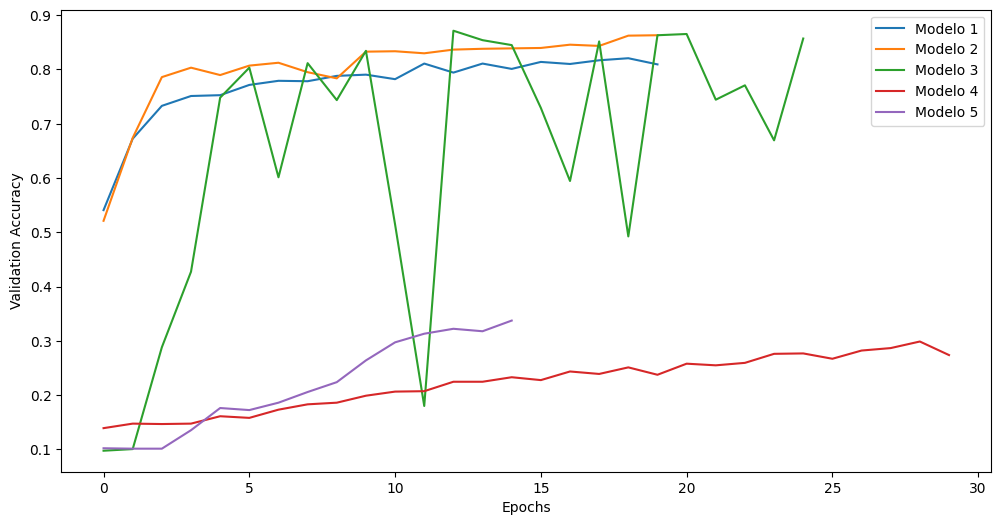

In [ ]:
import matplotlib.pyplot as plt

histories = [h1, h2, h3, h4, h5]
labels = ["Modelo 1","Modelo 2","Modelo 3","Modelo 4","Modelo 5"]
#Graficar
plt.figure(figsize=(12,6))
for h,l in zip(histories,labels):
    plt.plot(h.history["val_accuracy"],label=l)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

Podemos notar que los modelos 4 y 5, por eliminar información, tuvieron un desempeño pobre. El modelo que mantiene la mayor accuracy, estable y creciente a través de las épocas es el modelo 2, por lo que se selecciona como modelo ganador.  Esto se debe al cambio de kernel y por haber agregado más capas convolucionales.

**4. Modelo ganador**
En esta parte generé la gráfica donde comparé la exactitud del Modelo 2 entre los datos de entrenamiento y los de validación a lo largo de todas las épocas. Lo que buscaba era visualizar cómo iba aprendiendo el modelo y si existía alguna señal de sobreajuste.

Mounted at /content/drive


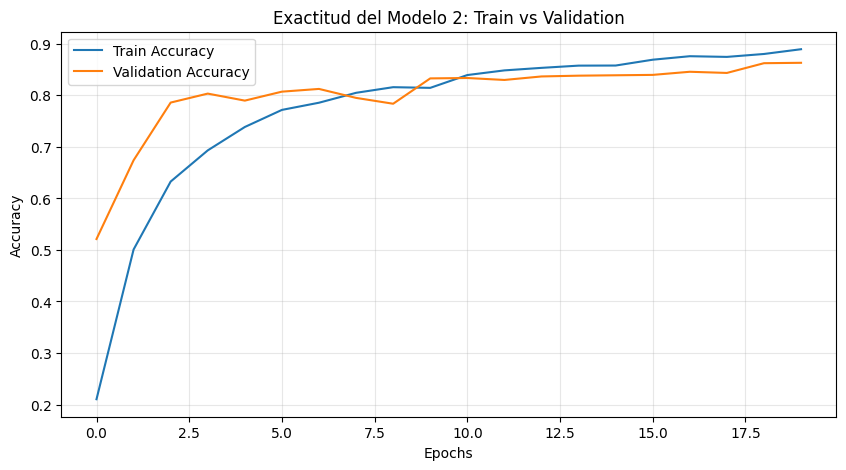

In [1]:
#Código agregado por reinicio de sesión
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
history = np.load("/content/drive/MyDrive/hist_m2.npy", allow_pickle=True).item()
#Fin
train_acc = history["accuracy"]
val_acc = history["val_accuracy"]
#Graficar
plt.figure(figsize=(10,5))
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Exactitud del Modelo 2: Train vs Validation")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



Podemos notar en la gráfica que el modelo inicia teniendo una mayor accuracy en train que en validación, pero mientras pasan las épocas esto cambia y empieza a tener mayor accuracyen validación. Esto se puede deber a la complejidad de las fotos en train, teniendo data augmentation, por lo que falla más en train pero tiene mejor desempeño en test. También podemos notar que empiezan ambos valores de accuracy muy bajos pero crecen rápidamente mientras pasan las épocas.
Con esta gráfic podemos sentirnos más seguros también que no caímos en sobreajuste.

**5. Reentrenamiento**
Como el modelo M2 fue el que obtuvo la mejor accuracy entre todas las arquitecturas probadas, decidí reentrenarlo utilizando ahora todo el dataset de entrenamiento completo, sin división para validación. El objetivo fue aprovechar el 100% de los datos disponibles para mejorar su capacidad de generalización antes de usarlo en la clasificación en tiempo real.

Mounted at /content/drive
Found 6631 images belonging to 10 classes.
Found 1869 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 137s 588ms/step - accuracy: 0.1741 - loss: 3.3785 - learning_rate: 5.0000e-04
Epoch 2/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 133s 641ms/step - accuracy: 0.5080 - loss: 1.5343 - learning_rate: 5.0000e-04
Epoch 3/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 140s 632ms/step - accuracy: 0.6502 - loss: 1.1110 - learning_rate: 5.0000e-04
Epoch 4/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 123s 590ms/step - accuracy: 0.7088 - loss: 0.9291 - learning_rate: 5.0000e-04
Epoch 5/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 123s 591ms/step - accuracy: 0.7566 - loss: 0.8005 - learning_rate: 5.0000e-04
Epoch 6/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 132s 636ms/step - accuracy: 0.7857 - loss: 0.6932 - learning_rate: 5.0000e-04
Epoch 7/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 145s 648ms/step - accuracy: 0.7925 - loss: 0.6581 - learning_rate: 5.0000e-04
Epoch 8/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 110s 526ms/step - accuracy: 0.8041 - loss: 0.6422 - learning_rate: 5.0000e-04
Epoch 9/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 103s 493ms/step 

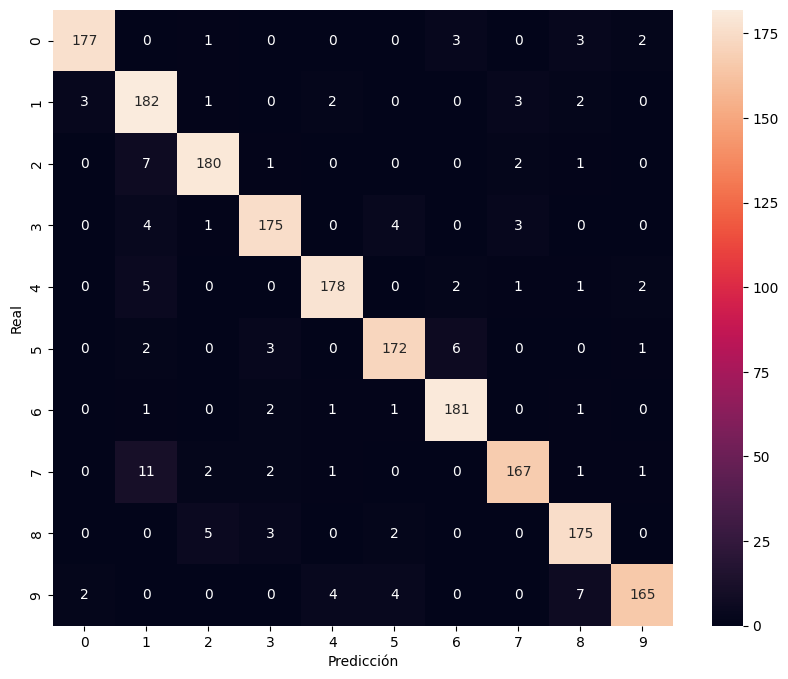

In [ ]:
#Código agregado por reinicio de sesión
from google.colab import drive
drive.mount('/content/drive')
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

shutil.copytree('/content/drive/MyDrive/Numbers','/content/Numbers', dirs_exist_ok=True)
#Fin

train_dir = "/content/Numbers/Train"
test_dir = "/content/Numbers/Test"
#Vuelve a definir y ajustar train y ahora test
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.25,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(280,280),
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    color_mode="grayscale"
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(280,280),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    color_mode="grayscale"
)
#Modelo seleccionado anteriormente
m2 = tf.keras.Sequential([
    tf.keras.layers.Input((280,280,1)),
    tf.keras.layers.Conv2D(32,5,padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,5,padding="same",activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,3,activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(train_gen.num_classes,activation="softmax")
])
m2.compile(optimizer=tf.keras.optimizers.Adam(0.0005),loss="categorical_crossentropy",metrics=["accuracy"]) #Compila
#Agrega para evitar sobreajuste, ajusta la tasa de aprendizaje y guarda el mejor modelo.
es = EarlyStopping(monitor="loss", patience=6, restore_best_weights=True)
ck = ModelCheckpoint('/content/drive/MyDrive/modelo_m2_fin.keras', monitor='loss', save_best_only=True)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=3, min_lr=1e-6)

#Entrenamiento usando todo el train
h2 = m2.fit(
    train_gen,
    epochs=40,
    callbacks=[es, ck, rlr]
)

m2.save('/content/drive/MyDrive/modelo_m2_fin.keras')
np.save('/content/drive/MyDrive/hist_m2_fin.npy', h2.history)


# Predicciones en test
pred = m2.predict(test_gen)
y_pred = np.argmax(pred, axis=1)
y_true = test_gen.classes
#Generar matriz de confusión
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
print(cm)
#Graficar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

Un accuracy total de 0.94 de nuestro modelo podemos decir, dentro de lo que cabe que es bueno. En cuanto a la matriz de confusión podemos ver que donde más se equivoca el modelo es entre 1 y 7, lo cual tiene sentido en cuanto a su figura. Podemos ver también que tiene una tendencia a predecir 1, ya que es la columna donde más vemos confusiones, esto podría arreglarse, por ejemplo: ajustando los pesos de clase para penalizar errores, aumento de datos para 1 y 7.
De hecho, el accuracy de este modelo es mayor que a su validación anterior, debido a que tuvo más datos con los cuales entrenarse y la implementación de medidas como Early Stopping, Model Checkpoint y ReduceLROnPlateau.

Finalmente, utilizaremos este modelo en nuestro programa de clasificación en tiempo real.